EDA on trawler dataset as a proxy for the more general dataset

In [3]:
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interactive, FloatSlider

import geopy.distance

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score, plot_roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV, KFold

from joblib import dump, load

import eda

RANDOM = 42

plt.style.use('ggplot')
%matplotlib inline
np.set_printoptions(suppress=True) # Suppress scientific notation where possible

In [26]:
fishing_path = "./data/fishing boats/"

trawler_raw_df = pd.read_csv(fishing_path + "trawlers.csv")

#trawler_raw_df = pd.read_csv(fishing_path + "trawlers.csv", parse_dates=['timestamp'], date_parser=lambda col: pd.to_datetime(col, unit='s'))

In [3]:
boats_raw_df = pd.read_csv(fishing_path + "fishing-vessels-v1.csv")

In [4]:
boats_raw_df

,mmsi,flag,geartype,length,tonnage,engine_power,active_2012,active_2013,active_2014,active_2015,active_2016
0,603100157,AGO,trawlers,32.808468,299.003814,733.826977,False,False,False,True,True
1,603100137,AGO,trawlers,34.568782,395.683171,864.960188,False,False,False,True,True
2,603100161,AGO,trawlers,28.822140,263.849149,651.809642,False,False,False,True,True
3,603100174,AGO,trawlers,30.721429,299.700916,703.796086,False,False,False,True,True
4,603100164,AGO,trawlers,37.479248,405.967747,850.976640,False,False,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...
73004,601764000,ZAF,drifting_longlines,17.032258,52.550920,207.818629,False,True,True,True,True
73005,601089100,ZAF,drifting_longlines,22.915622,180.506028,527.507463,False,False,False,True,True
73006,601849000,ZAF,drifting_longlines,19.692080,86.485661,362.553279,False,False,True,True,True
73007,601183700,ZAF,drifting_longlines,31.872860,307.446773,977.330342,False,False,True,True,True


In [5]:
trawler_raw_df

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source
0,1.252340e+12,2012-01-01 00:00:38,0.000000,0.000000,0.0,153.000000,52.458649,4.581200,-1.0,gfw
1,1.252340e+12,2012-01-01 00:33:13,0.000000,0.000000,0.0,153.000000,52.458668,4.581167,-1.0,gfw
2,1.252340e+12,2012-01-01 00:43:14,0.000000,0.000000,0.0,153.000000,52.458633,4.581183,-1.0,gfw
3,1.252340e+12,2012-01-01 00:59:55,0.000000,0.000000,0.0,153.000000,52.458649,4.581234,-1.0,gfw
4,1.252340e+12,2012-01-01 01:16:00,0.000000,0.000000,0.0,153.000000,52.458649,4.581183,-1.0,gfw
...,...,...,...,...,...,...,...,...,...,...
4369096,1.838128e+14,2016-11-24 23:36:39,172998.640625,239263.859375,11.2,166.800003,-42.847645,175.192535,-1.0,false_positives
4369097,1.838128e+14,2016-11-24 23:38:37,173595.859375,240246.062500,11.7,163.100006,-42.853741,175.194473,-1.0,false_positives
4369098,1.838128e+14,2016-11-24 23:40:39,174995.703125,241416.937500,11.2,168.699997,-42.860050,175.196487,-1.0,false_positives
4369099,1.838128e+14,2016-11-24 23:41:38,174995.703125,241416.937500,11.5,169.100006,-42.863056,175.197464,-1.0,false_positives


In [27]:
trawler_raw_df.groupby(['mmsi', 'timestamp']).count().sort_values(by='speed',ascending=False).iloc[0]

distance_from_shore    7
distance_from_port     7
speed                  7
course                 7
lat                    7
lon                    7
is_fishing             7
source                 7
Name: (51101297206144.0, 1373396587.0), dtype: int64

In [29]:
trawler_raw_df[(trawler_raw_df['mmsi'] == 51101297206144.0) & (trawler_raw_df['timestamp'] == 1373396587.0)]

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source
367687,5.110130e+13,1.373397e+09,999.975464,45275.812500,3.3,210.000000,52.706799,4.624710,-1.0,gfw
367688,5.110130e+13,1.373397e+09,1999.950928,45176.320312,7.0,136.199997,52.710381,4.621212,-1.0,gfw
367689,5.110130e+13,1.373397e+09,1999.950928,45176.320312,7.3,130.300003,52.710136,4.621666,-1.0,gfw
367690,5.110130e+13,1.373397e+09,1999.950928,46172.449219,1.6,201.199997,52.715179,4.620502,-1.0,gfw
367691,5.110130e+13,1.373397e+09,1999.950928,46172.449219,1.8,196.399994,52.715115,4.620470,-1.0,gfw
367692,5.110130e+13,1.373397e+09,1999.950928,46172.449219,2.3,188.300003,52.713581,4.620503,-1.0,gfw
367693,5.110130e+13,1.373397e+09,1999.950928,46172.449219,2.4,187.199997,52.714993,4.620437,-1.0,gfw


In [30]:
trawler_raw_df[(trawler_raw_df['is_fishing'] == 1) | (trawler_raw_df['is_fishing'] == 0)].groupby(['mmsi', 'timestamp']).count().sort_values(by='speed',ascending=False).iloc[0]

distance_from_shore    5
distance_from_port     5
speed                  5
course                 5
lat                    5
lon                    5
is_fishing             5
source                 5
Name: (269050323939773.0, 1372471501.0), dtype: int64

In [32]:
trawler_raw_df[(trawler_raw_df['mmsi'] == 269050323939773.0) & (trawler_raw_df['timestamp'] == 1372471501.0)] #pd.Timestamp('2013-06-29 02:05:01'))]

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source
3099729,2.690503e+14,1.372472e+09,0.0,3162.200195,0.0,161.000000,69.658546,18.973507,0.0,dalhousie_trawl
3099730,2.690503e+14,1.372472e+09,0.0,3162.200195,1.9,173.600006,69.658890,18.973034,0.0,dalhousie_trawl
3099731,2.690503e+14,1.372472e+09,0.0,3162.200195,2.0,201.300003,69.659775,18.973581,0.0,dalhousie_trawl
3099732,2.690503e+14,1.372472e+09,0.0,3162.200195,2.2,205.699997,69.659874,18.973690,0.0,dalhousie_trawl
3099733,2.690503e+14,1.372472e+09,0.0,3162.200195,4.3,241.600006,69.661179,18.977146,0.0,dalhousie_trawl


In [36]:
trawler_raw_df.groupby(['mmsi', 'timestamp']).count().sort_values(by='speed',ascending=False)

distance_from_shore  distance_from_port  speed  \
mmsi         timestamp                                                      
5.110130e+13 1.373397e+09                    7                   7      7   
             1.373394e+09                    7                   7      7   
             1.373411e+09                    7                   7      7   
             1.373421e+09                    7                   7      7   
3.491170e+13 1.367030e+09                    6                   6      6   
...                                        ...                 ...    ...   
2.748501e+14 1.430853e+09                    1                   1      0   
2.402260e+14 1.440911e+09                    1                   1      0   
1.252340e+12 1.436071e+09                    1                   1      0   
2.748501e+14 1.430809e+09                    1                   1      0   
             1.430764e+09                    1                   1      0   

                           course  lat  lon  is_fishing  source  
mmsi         timestamp                                           
5.110130e+13 1.373397e+09       7    7    7           7       7  
             1.373394e+09       7    7    7           7       7  
             1.373411e+09       7    7    7           7       7  
             1.373421e+09       7    7    7           7       7  
3.491170e+13 1.367030e+09       6    6    6           6       6  
...                           ...  ...  ...         ...     ...  
2.748501e+14 1.430853e+09       0    1    1           1       1  
2.402260e+14 1.440911e+09       0    1    1           1       1  
1.252340e+12 1.436071e+09       0    1    1           1       1  
2.748501e+14 1.430809e+09       0    1    1           1       1  
             1.430764e+09       0    1    1           1       1  

[4350243 rows x 8 columns]

In [47]:
trawler_raw_df.groupby(['mmsi', 'timestamp'])['source'].count().reset_index()[trawler_raw_df.groupby(['mmsi', 'timestamp'])['source'].count().reset_index()['source'] > 1].source.sum()

35438

In [6]:
trawler_raw_df.is_fishing.value_counts()

-1.000000    4191707
 0.000000     112999
 1.000000      61930
 0.666667       1639
 0.333333        760
 0.750000         34
 0.250000         32
Name: is_fishing, dtype: int64

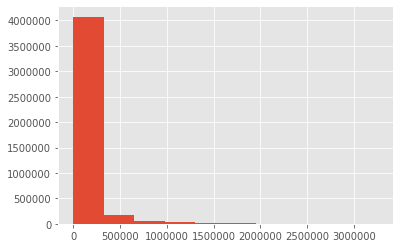

In [7]:
trawler_raw_df.distance_from_shore.hist();

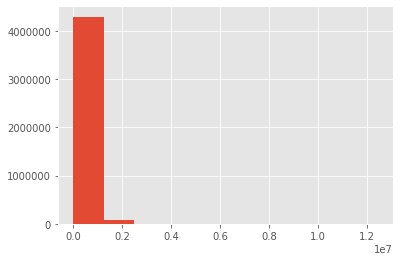

In [8]:
trawler_raw_df.distance_from_port.hist();

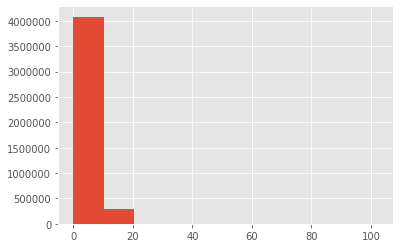

In [9]:
trawler_raw_df.speed.hist();

In [10]:
#trawler_sample_df = trawler_raw_df.sample(frac=0.1, random_state=RANDOM)
#sns.pairplot(trawler_sample_df[['distance_from_shore', 'distance_from_port']]);

In [11]:
trawler_raw_df.groupby('mmsi').mean().count()

distance_from_shore    49
distance_from_port     49
speed                  49
course                 49
lat                    49
lon                    49
is_fishing             49
dtype: int64

In [12]:
trawler_raw_df.source.value_counts()

gfw                2747809
false_positives     932922
dalhousie_trawl     688370
Name: source, dtype: int64

In [13]:
trawler_raw_df[trawler_raw_df.source == 'false_positives'].is_fishing.value_counts()

-1.0    928863
 0.0      4059
Name: is_fishing, dtype: int64

In [5]:
trawler_raw_df['year'] = pd.DatetimeIndex(trawler_raw_df['timestamp']).year
trawler_raw_df['month'] = pd.DatetimeIndex(trawler_raw_df['timestamp']).month
trawler_raw_df['weekday'] = pd.DatetimeIndex(trawler_raw_df['timestamp']).weekday
trawler_raw_df['hour'] = pd.DatetimeIndex(trawler_raw_df['timestamp']).hour

Monday = 0, Sunday = 6

In [6]:
trawler_raw_df['weekday'].value_counts()

1    666518
2    663196
0    655373
3    649654
4    606989
6    568238
5    559133
Name: weekday, dtype: int64

In [17]:
trawler_raw_df.year.value_counts()

2016    1447415
2015    1227224
2014     781342
2013     670707
2012     242413
Name: year, dtype: int64

In [11]:
trawler_mmsi = set(trawler_raw_df.mmsi.values)

In [19]:
trawler_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4369101 entries, 0 to 4369100
Data columns (total 15 columns):
 #   Column               Dtype         
---  ------               -----         
 0   mmsi                 float64       
 1   timestamp            datetime64[ns]
 2   distance_from_shore  float64       
 3   distance_from_port   float64       
 4   speed                float64       
 5   course               float64       
 6   lat                  float64       
 7   lon                  float64       
 8   is_fishing           float64       
 9   source               object        
 10  year                 int64         
 11  month                int64         
 12  day                  int64         
 13  hour                 int64         
 14  minute               int64         
dtypes: datetime64[ns](1), float64(8), int64(5), object(1)
memory usage: 500.0+ MB


In [20]:
trawler_mmsi.isdisjoint(set(boats_raw_df.mmsi.values))

True

Not surprising that there's no overlap between actual MMSI values and anonymised MMSI values

In [7]:
trawler_raw_df['is_new_mmsi'] = (trawler_raw_df.mmsi.shift(1) != trawler_raw_df.mmsi.shift(0))

In [8]:
prev_list = ['speed', 'lat', 'lon']

for col in prev_list:
    trawler_raw_df['prev_' + col] = trawler_raw_df[col].shift(1)
    trawler_raw_df['prev_' + col][trawler_raw_df.is_new_mmsi] = np.nan

In [23]:
trawler_raw_df[trawler_raw_df.mmsi == list(trawler_mmsi)[-1]][['lat', 'prev_lat']]

,lat,prev_lat
225070,54.126709,NaN
225071,54.126709,54.126709
225072,54.126709,54.126709
225073,54.126709,54.126709
225074,54.126709,54.126709
...,...,...
290837,53.772289,53.755215
290838,53.779480,53.772289
290839,53.793793,53.779480
290840,53.795856,53.793793


In [26]:
trawler_raw_df['dist_moved'] = trawler_raw_df.apply(eda.getdist, axis=1)

In [25]:
trawler_raw_df[trawler_raw_df.mmsi == list(trawler_mmsi)[-1]]['dist_moved']

225070         NaN
225071    0.000000
225072    0.001496
225073    0.000000
225074    0.000000
            ...   
290837    2.422407
290838    1.009121
290839    1.973746
290840    0.968547
290841    1.159580
Name: dist_moved, Length: 65772, dtype: float64

In [30]:
trawler_raw_df['time_taken'] = trawler_raw_df.timestamp.diff(1)
trawler_raw_df['time_taken'] = trawler_raw_df.time_taken.apply(lambda x: (datetime.timedelta.total_seconds(x) if pd.notnull(x) else np.nan))
trawler_raw_df['time_taken'][trawler_raw_df.is_new_mmsi] = np.nan

In [29]:
trawler_raw_df[trawler_raw_df.mmsi == list(trawler_mmsi)[-1]][['timestamp', 'time_taken']]

,timestamp,time_taken
225070,2013-02-08 11:12:30,NaN
225071,2013-02-08 11:24:32,722
225072,2013-02-08 11:36:33,721
225073,2013-02-08 11:48:37,724
225074,2013-02-08 12:06:30,1073
...,...,...
290837,2016-11-22 17:09:45,630
290838,2016-11-22 17:13:47,242
290839,2016-11-22 17:22:19,512
290840,2016-11-22 17:25:33,194


In [1]:
def get_cat_split_data(df, category, feature_cols, target_cols, test_size=.2, seed=42):

    rs = np.random.RandomState(seed)
    
    total_mmsi = df[category].unique() 
    test_mmsi = rs.choice(total_mmsi, 
                           size=int(total_mmsi.shape[0] * test_size), 
                           replace=False)

    df_tr = df[~df[category].isin(test_mmsi)]
    df_te = df[df[category].isin(test_mmsi)] 

    y_tr, y_te = df_tr[target_cols], df_te[target_cols]
    X_tr, X_te = df_tr[feature_cols], df_te[feature_cols]

    return X_tr, X_te, y_tr, y_te

In [44]:
trawler_raw_df.isna().sum()

mmsi                     0
timestamp                0
distance_from_shore      0
distance_from_port       0
speed                   78
course                  78
lat                      0
lon                      0
is_fishing               0
source                   0
year                     0
month                    0
weekday                  0
hour                     0
is_new_mmsi              0
prev_speed             127
prev_lat                49
prev_lon                49
time_taken              49
dist_moved              49
dtype: int64

In [45]:
trawler_raw_df.dropna(inplace=True)

In [46]:
trawler_df = trawler_raw_df[(trawler_raw_df.is_fishing == 1) | (trawler_raw_df.is_fishing == 0)]
trawler_noconsensus_df = trawler_raw_df[(trawler_raw_df.is_fishing > 0) & (trawler_raw_df.is_fishing < 1)]

In [47]:
feature_cols = ['distance_from_shore', 'distance_from_port',
       'speed', 'course', 'lat', 'lon', 'month', 'weekday', 'hour', 
       'prev_speed', 'dist_moved', 'time_taken']

train_X, test_X, train_y, test_y = get_cat_split_data(trawler_df, 'mmsi', feature_cols, 'is_fishing')

train_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114703 entries, 60646 to 4324375
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   distance_from_shore  114703 non-null  float64
 1   distance_from_port   114703 non-null  float64
 2   speed                114703 non-null  float64
 3   course               114703 non-null  float64
 4   lat                  114703 non-null  float64
 5   lon                  114703 non-null  float64
 6   month                114703 non-null  int64  
 7   weekday              114703 non-null  int64  
 8   hour                 114703 non-null  int64  
 9   prev_speed           114703 non-null  float64
 10  dist_moved           114703 non-null  float64
 11  time_taken           114703 non-null  float64
dtypes: float64(9), int64(3)
memory usage: 11.4 MB


In [48]:
model_dummy = DummyClassifier(random_state=RANDOM)
model_dummy.fit(train_X, train_y)

DummyClassifier(constant=None, random_state=42, strategy='warn')

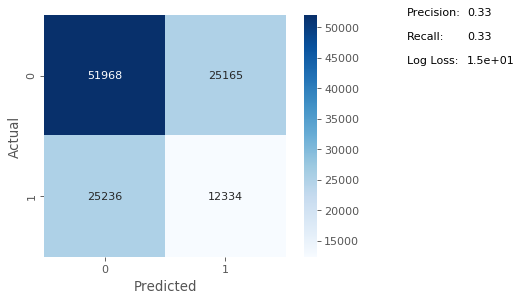

In [49]:
eda.make_confusion_matrix(model_dummy, train_X, train_y, threshold=0.5, show_metrics=True)

In [50]:
model_knn = KNeighborsClassifier()

#create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 25)}

#use gridsearch to test all values for n_neighbors
model_knn_gscv = GridSearchCV(model_knn, param_grid, cv=KFold(n_splits=5, shuffle=True, random_state=RANDOM), scoring='recall')

#fit model to data
model_knn_gscv.fit(train_X, train_y)
model_knn_gscv.best_params_

{'n_neighbors': 7}

In [51]:
pd.DataFrame(model_knn_gscv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.839920,0.049149,2.048099,0.465266,1,{'n_neighbors': 1},0.849718,0.861861,0.857755,0.866916,0.863480,0.859946,0.005902,12
1,1.008582,0.328592,2.218780,0.262135,2,{'n_neighbors': 2},0.761780,0.765606,0.765336,0.777392,0.768671,0.767757,0.005289,24
2,0.787267,0.076391,2.078988,0.186970,3,{'n_neighbors': 3},0.866518,0.873406,0.862711,0.876002,0.870101,0.869747,0.004745,9
3,0.809455,0.129444,2.077673,0.099738,4,{'n_neighbors': 4},0.809818,0.817157,0.810608,0.825762,0.815546,0.815778,0.005725,23
4,0.843746,0.138185,2.320375,0.148635,5,{'n_neighbors': 5},0.871112,0.873943,0.867533,0.880412,0.875132,0.873626,0.004286,3
5,0.792219,0.045878,2.085542,0.092910,6,{'n_neighbors': 6},0.830555,0.834340,0.828422,0.841261,0.832495,0.833415,0.004390,22
6,0.756277,0.058481,2.174216,0.137319,7,{'n_neighbors': 7},0.869930,0.876493,0.869408,0.881347,0.874338,0.874303,0.004416,1
7,0.842989,0.050555,2.251004,0.079169,8,{'n_neighbors': 8},0.838430,0.844140,0.835253,0.848744,0.838189,0.840951,0.004845,21
8,0.813496,0.090223,2.250200,0.130457,9,{'n_neighbors': 9},0.870455,0.879178,0.866729,0.878006,0.874603,0.873794,0.004657,2
9,0.840396,0.056701,2.419800,0.186760,10,{'n_neighbors': 10},0.843287,0.850718,0.838200,0.853421,0.843088,0.845743,0.005544,20


In [52]:
plt.style.use('ggplot')
np.set_printoptions(suppress=True) # Suppress scientific notation where possible

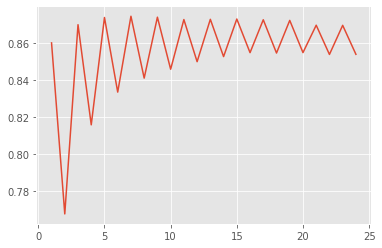

In [53]:
sns.lineplot(x=np.arange(1,25), y=model_knn_gscv.cv_results_['mean_test_score']);

In [54]:
model_knn_gscv.refit_time_

0.9984095096588135

In [32]:
knn_y =  model_knn_gscv.predict(train_X)

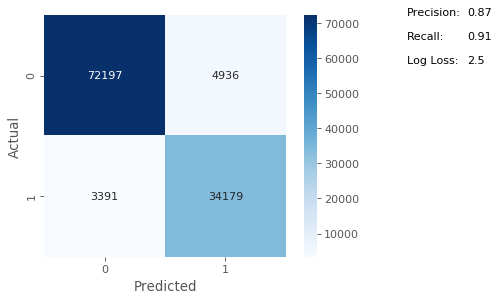

In [56]:
eda.make_confusion_matrix(model_knn_gscv, train_X, train_y, threshold=0.5, show_metrics=True)

Performance is decent

In [35]:
interactive(lambda threshold: eda.make_confusion_matrix(model_knn_gscv, train_X, train_y, threshold=threshold, show_metrics=True), threshold=(0.0,1.0,0.01))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.01), Output()), _dom_cla…

In [120]:
model_logreg = LogisticRegression()

#create a dictionary of all values we want to test for n_neighbors
logreg_param = {'penalty': ['l2', 'none'],'C': np.logspace(-4, 4, 20)}

#use gridsearch to test all values for n_neighbors
model_logreg_gscv = GridSearchCV(model_logreg, param_grid=logreg_param, cv=KFold(n_splits=5, shuffle=True, random_state=RANDOM), scoring='recall')

#fit model to data
model_logreg_gscv.fit(train_X, train_y)
model_logreg_gscv.best_params_

{'C': 0.0001, 'penalty': 'l2'}

In [103]:
model_logreg_cv = LogisticRegressionCV(cv=KFold(n_splits=5, shuffle=True, random_state=RANDOM), scoring='recall')
model_logreg_cv.fit(train_X, train_y)

model_logreg_cv.get_params()

{'Cs': 10,
 'class_weight': None,
 'cv': KFold(n_splits=5, random_state=42, shuffle=True),
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1.0,
 'l1_ratios': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'refit': True,
 'scoring': 'recall',
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0}

In [50]:
interactive(lambda threshold: eda.make_confusion_matrix(model_logreg_cv, test_X, test_y, threshold=0.28, show_metrics=True), threshold=(0.0,1.0,0.01))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.01), Output()), _dom_cla…

In [101]:
model_logreg_cv.scores_

{1.0: array([[0.41552789, 0.41552789, 0.35772852, 0.35772852, 0.35772852,
         0.35772852, 0.35772852, 0.35772852, 0.35772852, 0.35772852],
        [0.35294704, 0.35294704, 0.35294704, 0.35294704, 0.35294704,
         0.35294704, 0.35294704, 0.35294704, 0.35294704, 0.35294704],
        [0.39458198, 0.39458198, 0.39458198, 0.39458198, 0.39458198,
         0.39458198, 0.39458198, 0.39458198, 0.39458198, 0.39458198],
        [0.42236842, 0.42236842, 0.42236842, 0.42236842, 0.42236842,
         0.42236842, 0.36163968, 0.36659919, 0.36659919, 0.36659919],
        [0.41138855, 0.41128705, 0.41138855, 0.41138855, 0.38398295,
         0.3772838 , 0.37068616, 0.37068616, 0.37068616, 0.37068616]])}

In [121]:
results_logreg_gscv = pd.DataFrame(model_logreg_gscv.cv_results_)

results_logreg_gscv

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.034800,0.020703,0.000000,0.000000,0.0001,l1,"{'C': 0.0001, 'penalty': 'l1'}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,60
1,0.887338,0.322811,0.034253,0.010623,0.0001,l2,"{'C': 0.0001, 'penalty': 'l2'}",0.415528,0.352947,0.394582,0.422368,0.411389,0.399363,0.024950,1
2,1.031193,0.327380,0.043496,0.003652,0.0001,none,"{'C': 0.0001, 'penalty': 'none'}",0.415528,0.351052,0.394582,0.422368,0.411389,0.398984,0.025656,3
3,0.036410,0.003341,0.000000,0.000000,0.000263665,l1,"{'C': 0.00026366508987303583, 'penalty': 'l1'}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,44
4,1.019722,0.315463,0.046285,0.002990,0.000263665,l2,"{'C': 0.00026366508987303583, 'penalty': 'l2'}",0.415528,0.351052,0.394582,0.422368,0.411389,0.398984,0.025656,3
5,0.789371,0.330536,0.030668,0.004296,0.000263665,none,"{'C': 0.00026366508987303583, 'penalty': 'none'}",0.415528,0.351052,0.394582,0.422368,0.411389,0.398984,0.025656,3
6,0.031318,0.002038,0.000000,0.000000,0.000695193,l1,"{'C': 0.0006951927961775605, 'penalty': 'l1'}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,43
7,0.713807,0.395339,0.027600,0.003094,0.000695193,l2,"{'C': 0.0006951927961775605, 'penalty': 'l2'}",0.415528,0.351551,0.394582,0.422368,0.411389,0.399084,0.025470,2
8,0.689354,0.201493,0.029316,0.002414,0.000695193,none,"{'C': 0.0006951927961775605, 'penalty': 'none'}",0.415528,0.351052,0.394582,0.422368,0.411389,0.398984,0.025656,3
9,0.018882,0.002979,0.000000,0.000000,0.00183298,l1,"{'C': 0.0018329807108324356, 'penalty': 'l1'}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,41


In [122]:
results_logreg_gscv[results_logreg_gscv.param_penalty == 'none'].mean_test_score

2     0.398984
5     0.398984
8     0.398984
11    0.398984
14    0.398984
17    0.398984
20    0.398984
23    0.398984
26    0.398984
29    0.398984
32    0.398984
35    0.398984
38    0.398984
41    0.398984
44    0.398984
47    0.398984
50    0.398984
53    0.398984
56    0.398984
59    0.398984
Name: mean_test_score, dtype: float64

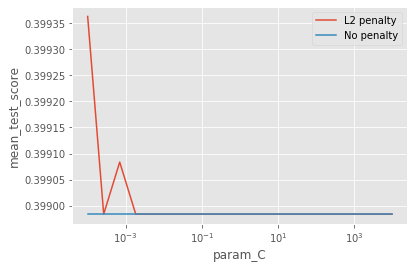

In [123]:
sns.lineplot(x=results_logreg_gscv.param_C, y=results_logreg_gscv[results_logreg_gscv.param_penalty == 'l2'].mean_test_score, label="L2 penalty").set(xscale='log')
sns.lineplot(x=results_logreg_gscv.param_C, y=results_logreg_gscv[results_logreg_gscv.param_penalty == 'none'].mean_test_score, label="No penalty").set(xscale='log');

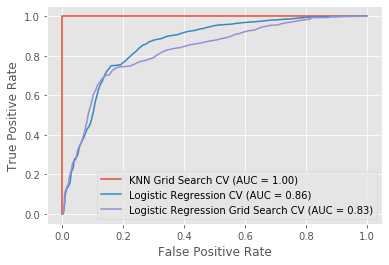

In [119]:
fig, ax = plt.subplots()

plot_roc_curve(model_knn_gscv, train_X, train_y, name="KNN Grid Search CV", ax=ax)
plot_roc_curve(model_logreg_cv, train_X, train_y, name="Logistic Regression CV", ax=ax)
plot_roc_curve(model_logreg_gscv, train_X, train_y, name="Logistic Regression Grid Search CV", ax=ax);

In [39]:
threshold = 0.28

logreg_y = (model_logreg_cv.predict_proba(train_X)[:, 1] >= threshold)

f1_score(train_y, logreg_y)

0.7278022432053853

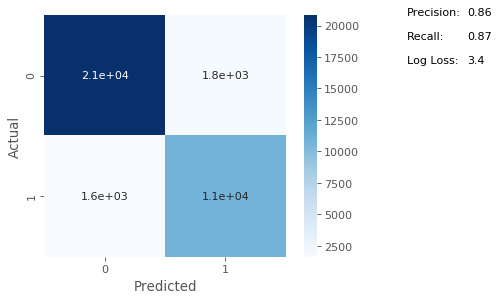

In [40]:
eda.make_confusion_matrix(model_knn_gscv, test_X, test_y, threshold=0.5, show_metrics=True)

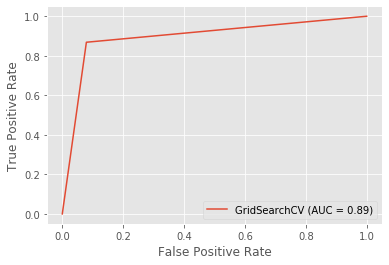

In [41]:
plot_roc_curve(model_knn_gscv, test_X, test_y);

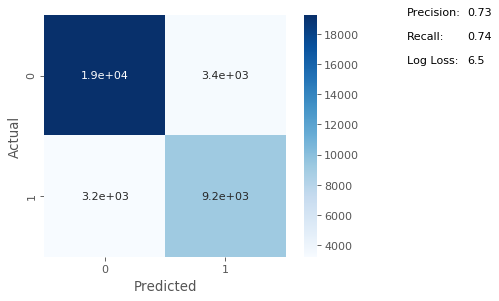

In [42]:
eda.make_confusion_matrix(model_logreg_cv, test_X, test_y, threshold=0.28, show_metrics=True)

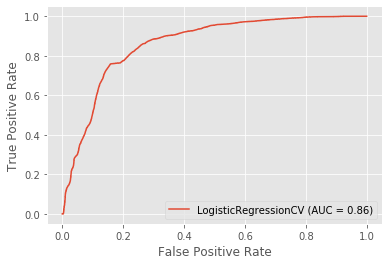

In [43]:
plot_roc_curve(model_logreg_cv, test_X, test_y);

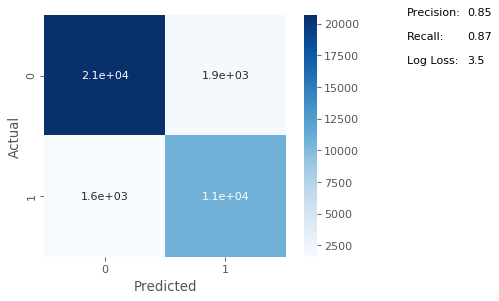

In [71]:
eda.make_confusion_matrix(model_knn2_gscv, test_X, test_y, threshold=0.50, show_metrics=True)

Better performance

In [61]:
dump(model_knn_gscv, "knn_model_trawler.joblib")

['knn_model_trawler.joblib']

In [63]:
dump(model_logreg_cv, "lr_model_trawler.joblib")

['lr_model_trawler.joblib']